In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline 
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import random
from collections import defaultdict, Counter
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
C:\Users\onomatopeia\.conda\envs\modelling-ncov2019\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
import os
if os.getcwd().endswith('notebooks'):
    os.chdir(os.path.join(os.getcwd(), os.pardir))
# os.getcwd()

In [4]:
from bootstrapping import attack_rate

In [19]:
from bootstrapping import settings

In [5]:
from statsmodels.distributions.empirical_distribution import ECDF

In [6]:
index_cases = attack_rate.get_patient_data()

In [7]:
index_cases.head()

,age,min_household_size,gender,voy
30,43,13,0,14
31,37,12,1,12
32,49,12,1,12
33,69,12,1,02
34,26,10,1,14


## Apartments

In [14]:
all_people, all_households = attack_rate.get_data(recalculate=True)

In [15]:
households_sizes = {h_index: len(inhabitants) for h_index, inhabitants in all_households.items()}

In [16]:
np.mean(list(households_sizes.values()))

3.349991265937464

In [20]:
all_people, all_households = attack_rate.get_data(recalculate=True, nsp_folder = settings.data_dir / 'nsp_households')

In [21]:
households_sizes = {h_index: len(inhabitants) for h_index, inhabitants in all_households.items()}

In [22]:
np.mean(list(households_sizes.values()))

2.9827675908789604

In [11]:
np.var(list(households_sizes.values()))

3.9123108029690647

In [12]:
c = Counter(list(households_sizes.values()))

In [13]:
household_sizes_grouped = dict(c)

In [14]:
household_sizes_grouped[1]

385867

### Old calculations

In [15]:
def get_sample_mean(household_sizes):
    nominator = 0
    denominator = sum(household_sizes.values())
    for k, v in household_sizes.items():
        nominator += k*v
    return nominator / denominator

In [16]:
sample_mean = get_sample_mean(household_sizes_grouped)
sample_mean

3.349991265937464

In [17]:
def get_sample_variance(household_sizes):
    sum_of_squares = 0
    denominator_mean = sum(household_sizes.values())
    denominator_var = denominator_mean - 1
    for k, v in household_sizes.items():
        sum_of_squares += (k**2)*v
    return (sum_of_squares - sum_of_squares/denominator_mean) / denominator_var

In [18]:
get_sample_variance(household_sizes_grouped)

15.134752284826357

# Household size given age

In [19]:
def get_household_sizes_given_age(people, household_sizes):
    household_sizes_given_age = defaultdict(list)
    for (gender, age), household_indices in people.items():
        for index in household_indices:
            household_sizes_given_age[age].append(household_sizes[index])
    return household_sizes_given_age

In [20]:
def get_mean_household_size_given_age_distribution(people, household_sizes, reload=False):
    
    nsp_mean_household_size_given_age_path = Path(r'd:\coronavirus\attack rate\data\nsp_mean_household_size_given_age.csv')\
        .resolve()
    
    if not reload and nsp_mean_household_size_given_age_path.is_file():
        return pd.read_csv(str(nsp_mean_household_size_given_age_path))
    
    nsp_household_sizes_given_age = get_household_sizes_given_age(people, household_sizes)
        
    nsp_mean_household_size_given_age = {}
    nsp_var_household_size_given_age = {}
    nsp_std_household_size_given_age = {}
    for key, values in nsp_household_sizes_given_age.items():
        nsp_mean_household_size_given_age[key] = np.mean(values)
        nsp_var_household_size_given_age[key] = np.var(values)
        nsp_std_household_size_given_age[key] = np.std(values)
        
    nsp_mean_household_size_given_age_df = pd.DataFrame(data={
        'age': sorted(nsp_mean_household_size_given_age.keys()), 
        'mean_household_size': [nsp_mean_household_size_given_age[x] for x in sorted(nsp_mean_household_size_given_age.keys())],
        'var_household_size': [nsp_var_household_size_given_age[x] for x in sorted(nsp_var_household_size_given_age.keys())], 
        'std_household_size': [nsp_std_household_size_given_age[x] for x in sorted(nsp_std_household_size_given_age.keys())]})
    nsp_mean_household_size_given_age_df.to_csv(str(nsp_mean_household_size_given_age_path), index=False, encoding='utf-8')
        
    return nsp_mean_household_size_given_age_df

In [21]:
reload = False
nsp_mean_household_size_given_age = get_mean_household_size_given_age_distribution(all_people, households_sizes, reload)
mean_household_size_given_age_dict = {row['age']: row['mean_household_size'] 
                                      for idx, row in nsp_mean_household_size_given_age.iterrows()}

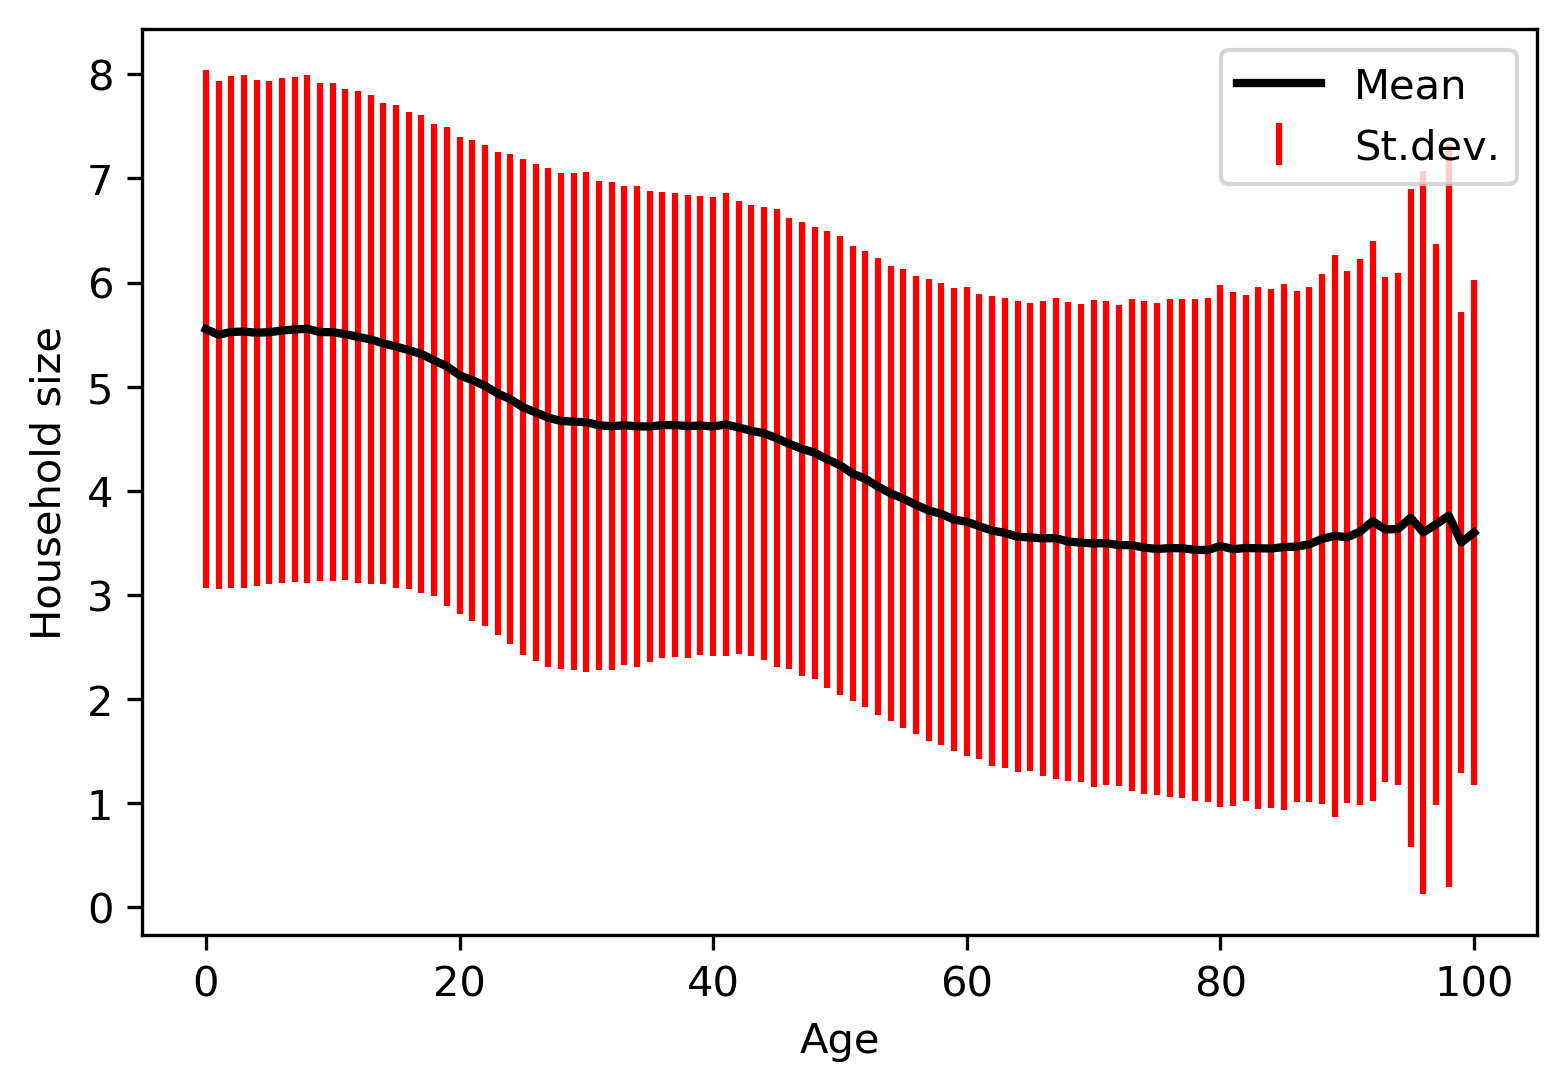

In [22]:
plt.figure(dpi=300)
plt.plot(nsp_mean_household_size_given_age['age'], nsp_mean_household_size_given_age['mean_household_size'], 'k-', lw=2, 
         label='Mean')
plt.xlabel('Age')
plt.ylabel('Household size')
plt.errorbar(nsp_mean_household_size_given_age['age'], nsp_mean_household_size_given_age['mean_household_size'], 
             nsp_mean_household_size_given_age['std_household_size'], 
             linestyle='None', marker='^', c='r', label='St.dev.', fmt='none')
plt.legend()
plt.savefig('PL_mean_apartment_size_given_age_NSP2011_std.png', bbox_inches='tight')
plt.show()

# Plot household sizes

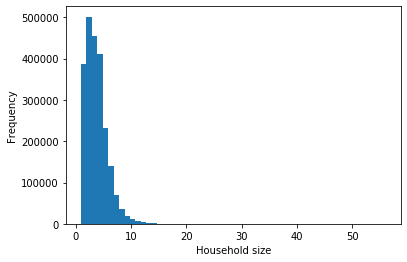

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.figure()
plt.hist(list(households_sizes.values()), bins=max(households_sizes.values()))
plt.xlabel('Household size')
plt.ylabel('Frequency')
# plt.title('Frequency of occurrence of households of given headcount in Poland')
plt.savefig('PL_household_sizes_in_poland.png')
plt.show()

In [24]:
ecdf_household_sizes_in_poland = ECDF(list(households_sizes.values()))

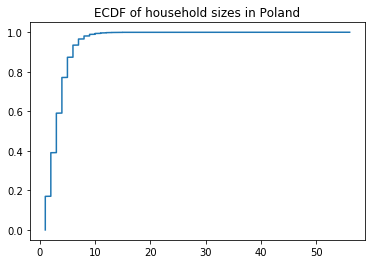

In [25]:
plt.plot(ecdf_household_sizes_in_poland.x, ecdf_household_sizes_in_poland.y, label='ECDF of household sizes in Poland')
plt.title('ECDF of household sizes in Poland')
plt.show()

# Mean household size among index cases

For each index case get their age and the respective mean household size. Plot the histogram

In [26]:
mean_household_size_given_age_dict[43]

4.578216902837285

In [27]:
spreaders_household_sizes = [mean_household_size_given_age_dict[age] for age in index_cases.age] 

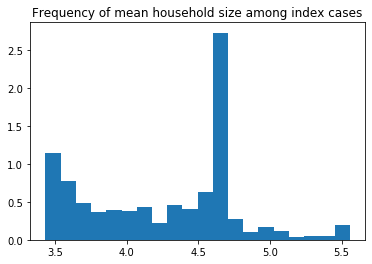

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
plt.hist(spreaders_household_sizes, bins=20, density=True)
plt.title('Frequency of mean household size among index cases')
plt.savefig('secondary_infections_household_sizes.png')
plt.show()

# Age distribution in NSP2011

In [31]:
age_counts = {age: len(people) for (gender, age), people in all_people.items()}

In [32]:
age_counts[23]

54186

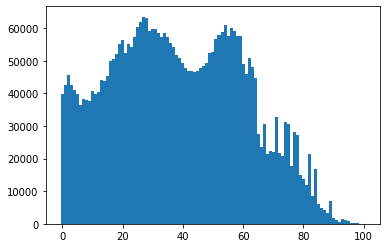

In [34]:
plt.figure()
plt.bar(list(age_counts.keys()), list(age_counts.values()), width=1)
plt.savefig('age_distrib_population.png')
plt.show()

# Age distribution within the general population of Poland (2019.06)

In [37]:
age = pd.read_csv(str(attack_rate.data_dir / 'age_in_general_population.csv'))

In [38]:
age.shape

(37598708, 1)

In [40]:
age.max()

age    85
dtype: int64

In [43]:
age_counts = age.groupby('age').size()

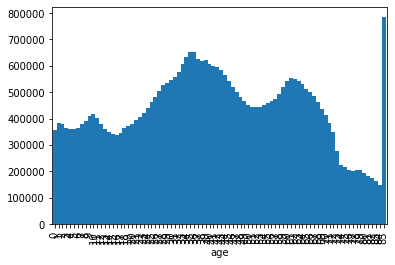

In [47]:
age_counts.plot(kind='bar', width=1)
plt.show()

In [48]:
from scipy.stats import ks_2samp
import random

In [49]:
x = index_cases.age

In [54]:
y = age.age

In [55]:
ks_2samp(random.sample(x[x < 85].tolist(), 1000), random.sample(y[y<85].tolist(), 1000))

Ks_2sampResult(statistic=0.197, pvalue=2.209740777708452e-17)

In [56]:
ks_2samp(x[x<85], y[y<85])

Ks_2sampResult(statistic=0.1759311275456974, pvalue=2.8508567925964573e-256)

<span style='color:red'>Tutaj skończyłam</span>

### Inclusion of secondary household infections drawn from the bootstrapping procedure

#### Age distribution in 2011 Census

In [8]:
def get_data():
    import pickle

    try:
        with open('all_people.pickle', 'rb') as handle:
            all_people = pickle.load(handle)

        with open('all_households.pickle', 'rb') as handle:
            all_households = pickle.load(handle)
        
    except FileNotFoundError:
        all_people = defaultdict(list)
        all_households = defaultdict(list)

        nsp_folder = Path(r'data/simulations/nsp2011_powiats/apartments').resolve()

        for folder in nsp_folder.iterdir():
            population_voy = pd.read_csv(str(folder / 'population.csv'))
            for idx, row in population_voy.iterrows():
                all_people[row.age].append(row.household_index)
                all_households[row.household_index].append(row.age)

        with open('all_people.pickle', 'wb') as handle:
            pickle.dump(all_people, handle)

        with open('all_households.pickle', 'wb') as handle:
            pickle.dump(all_households, handle)
            
    return all_people, all_households

In [9]:
all_people, _ = get_data()

In [10]:
age_distribution_census2011 = []
for key, val in all_people.items():
    if key < 80:
        age_distribution_census2011.extend([key] * len(val))

In [10]:
df = pd.read_csv('wiek_domki_Agata.csv')

In [11]:
df2 = pd.read_csv('wiek_domki_Agata2.csv')

In [12]:
index_cases_1 = df['earliest_age_in_address']

In [13]:
index_cases_1 = index_cases_1[index_cases_1 < 80]

In [14]:
index_cases_2 = df2['earliest_age_in_address']

In [15]:
index_cases_2 = index_cases_2[index_cases_2 < 80]

In [16]:
slist2 =[]
counter = 0
for x in df2.later_ages_in_address:
    if len(x) > 0:
        for token in x[1:-1].split(','):
            if len(token) > 0:
                counter += 1
                slist2.append(int(float(token.strip())))        


In [17]:
slist =[]
counter = 0
for x in df.later_ages_in_address:
    if len(x) > 0:
        for token in x[1:-1].split(','):
            if len(token) > 0:
                counter += 1
                slist.append(int(float(token.strip())))        


In [18]:
df2

,Unnamed: 0,IDAdres5,earliest_age_in_address,later_ages_in_address,Województwo
0,0,L234_S450_32_,51.0,"[18.0, 28.0, 29.0, 48.0]",ŁÓDZKIE
1,1,L220__57_,4.0,[],MAZOWIECKIE
2,2,O600_P200_10_,30.0,[],ŚLĄSKIE
3,3,Y200_G654_19_9,39.0,[],ŚLĄSKIE
4,4,T600_K630_9_,58.0,[25.0],KUJAWSKO-POMORSKIE
...,...,...,...,...,...
8171,12018,K620_J252_5_,40.0,[],MAŁOPOLSKIE
8172,12028,W620_P221_12A_45,2.0,"[34.0, 30.0]",MAZOWIECKIE
8173,12033,B623_B623_39_2,46.0,[],DOLNOŚLĄSKIE
8174,12035,W352_P632_51_7,41.0,[],DOLNOŚLĄSKIE


In [19]:
df

,Unnamed: 0,IDAdres5,earliest_age_in_address,later_ages_in_address,Województwo
0,0,L234_S450_32_,51.0,"[18.0, 28.0, 29.0, 48.0]",ŁÓDZKIE
1,1,L220__57_,4.0,[],MAZOWIECKIE
2,2,O600_P200_10_,30.0,[],ŚLĄSKIE
3,3,Y200_G654_19_9,39.0,[],ŚLĄSKIE
4,4,T600_K630_9_,58.0,[25.0],KUJAWSKO-POMORSKIE
...,...,...,...,...,...
8267,12018,K620_J252_5_,40.0,[],MAŁOPOLSKIE
8268,12028,W620_P221_12A_45,2.0,"[34.0, 30.0]",MAZOWIECKIE
8269,12033,B623_B623_39_2,46.0,[],DOLNOŚLĄSKIE
8270,12035,W352_P632_51_7,41.0,[],DOLNOŚLĄSKIE


In [20]:
s = pd.Series(slist)

In [21]:
young = s[s<80]

In [22]:
s2 = pd.Series(slist2)

In [23]:
young2 = s[s<80]

In [24]:
population_path = Path(r'data/simulations/20200516_2124').resolve()

In [25]:
# popul_age = pd.Series(data=0, index=list(range(86)), name='age')
popul_age = dict()

In [26]:
for folder in population_path.iterdir():
    popul_voy = pd.read_csv(str(population_path / folder / 'population.csv'))
    popul_age[folder] = popul_voy.age

In [27]:
age = pd.concat((popul_age[folder] for folder in population_path.iterdir()))

In [28]:
age.shape

(37598708,)

In [29]:
age.to_csv('age_in_general_population.csv', index=False)

In [30]:
y = age[age<80]

In [14]:
def from_file_to_ecdf(file_path):
    import pickle
    import numpy as np
    from statsmodels.distributions.empirical_distribution import ECDF
    
    with open(file_path, 'rb') as handle:
        interim_distrib = pickle.load(handle)
    df = pd.DataFrame(data=interim_distrib)
    z = df.mean()
    
    u = []
    for item in z.iteritems():
        if item[0] < 80:
            u.extend([item[0]] * int(np.round(item[1])))
    return u

In [15]:
u_experiment = from_file_to_ecdf('results10000_agedistribution_20200627_406080_full.pickle')

In [18]:
import pickle
file_path = 'results10000_agedistribution_20200627_406080_full.pickle'
with open(file_path, 'rb') as handle:
    interim_distrib = pickle.load(handle)
df = pd.DataFrame(data=interim_distrib)
z = df.mean()

In [19]:
z

0      463.5196
1      517.0694
2      524.7384
3      495.7746
4      473.7573
         ...   
96       3.9230
97       2.6778
98       1.8393
99       0.9888
100      1.5767
Length: 101, dtype: float64

In [20]:
u_experiment[-1]

79

In [13]:
ecdf_experiment

In [41]:
ecdf_no_conditioning = from_file_to_ecdf('results10000_agedistribution_20200620_406080_4.pickle')

In [42]:
ecdf_no_voy = from_file_to_ecdf('results10000_agedistribution_20200620_406080_3.pickle')

In [43]:
ecdf_full_conditioning = from_file_to_ecdf('results10000_agedistribution_20200620_406080_2.pickle')

In [44]:
from statsmodels.distributions.empirical_distribution import ECDF

In [45]:
ecdf_y2 = ECDF(young2)

In [46]:
ecdf = ECDF(young)
ecdf2 = ECDF(y)

In [47]:
ecdf_census = ECDF(age_distribution_census2011)

In [48]:
ecdf_index1 = ECDF(index_cases_1)
ecdf_index2 = ECDF(index_cases_2)

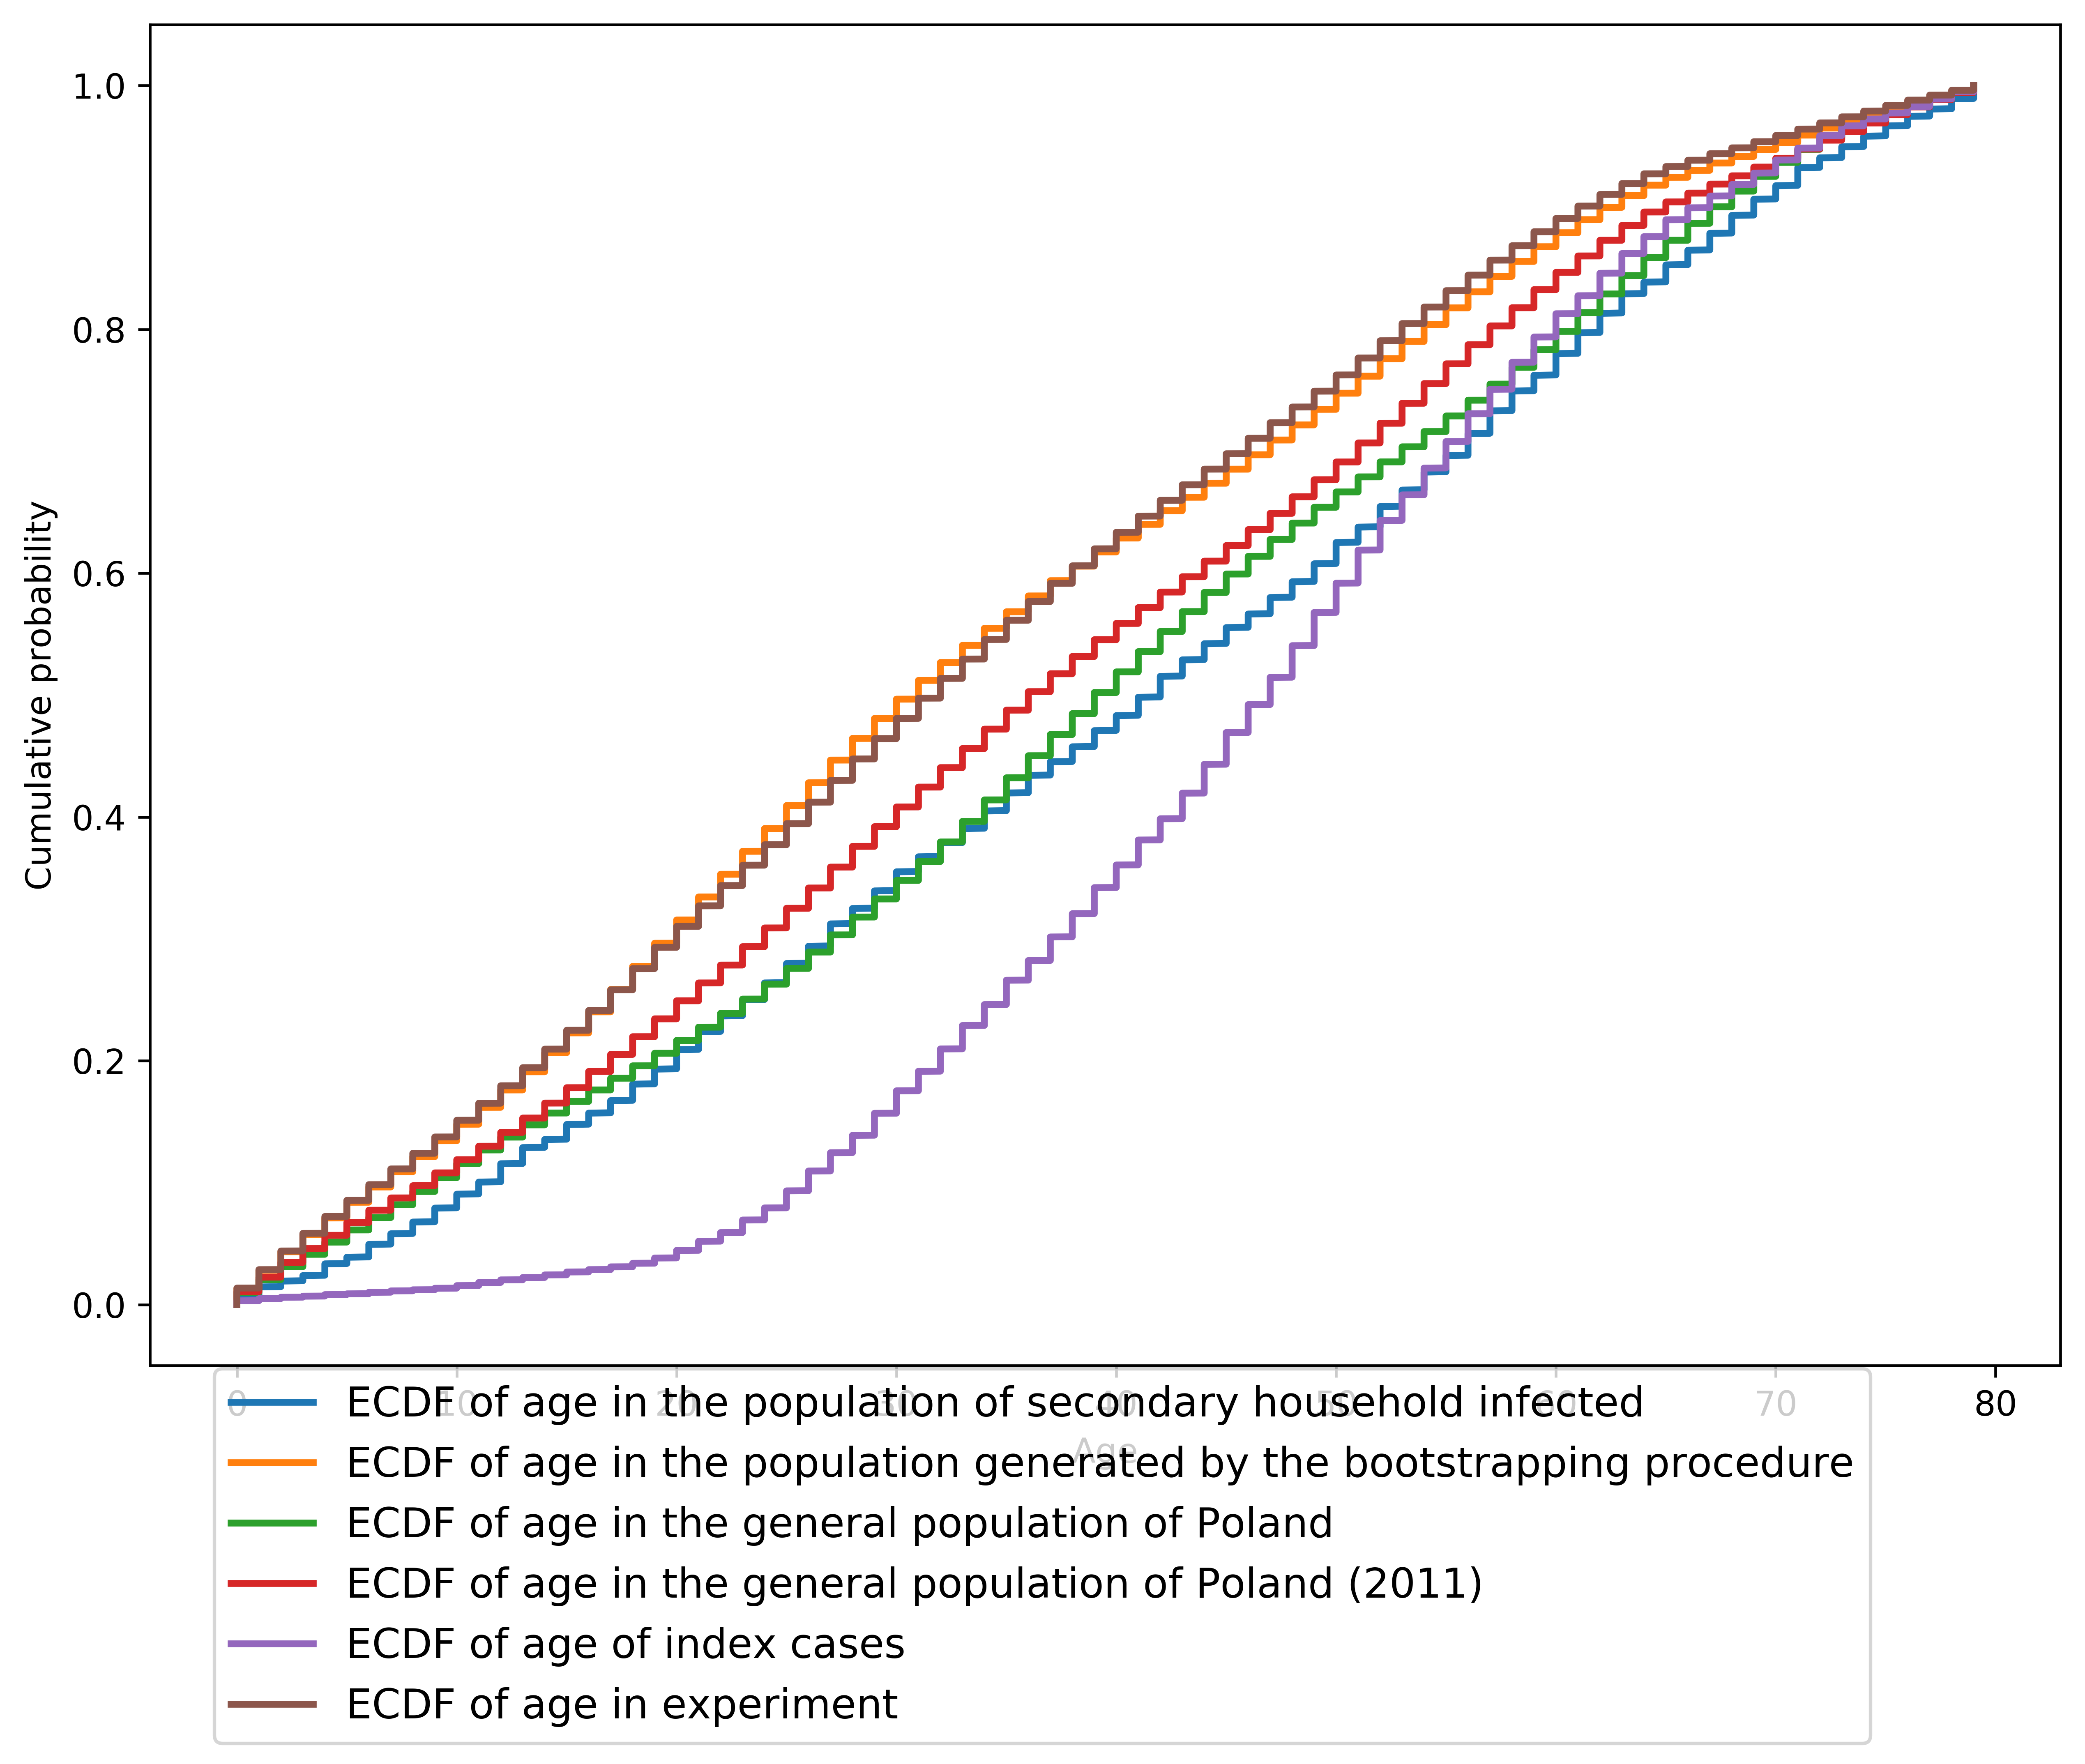

In [50]:

import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10, 8), dpi=600)
ax.plot(ecdf.x, ecdf.y, label='ECDF of age in the population of secondary household infected', linestyle='-', lw=2)
# ax.plot(ecdf_y2.x, ecdf_y2.y, label='ECDF of age in the population of secondary household infected (excluding large households)', linestyle='--', lw=2)
# ax.plot(ecdf_no_voy.x, ecdf_no_voy.y, label='ECDF of age in the population generated by the bootstrapping procedure (min household size)', linestyle='-', lw=2)
ax.plot(ecdf_full_conditioning.x, ecdf_full_conditioning.y, label='ECDF of age in the population generated by the bootstrapping procedure', linestyle='-', lw=2)
# ax.plot(ecdf_no_conditioning.x, ecdf_no_conditioning.y, label='ECDF of age in the population generated by the bootstrapping procedure (no conditions)', linestyle='--', lw=2)
ax.plot(ecdf2.x, ecdf2.y, label='ECDF of age in the general population of Poland', lw=2)
ax.plot(ecdf_census.x, ecdf_census.y, label='ECDF of age in the general population of Poland (2011)', lw=2)
ax.plot(ecdf_index1.x, ecdf_index1.y, label='ECDF of age of index cases', linestyle='-', lw=2)
ax.plot(ecdf_experiment.x, ecdf_experiment.y, label='ECDF of age in experiment', linestyle='-', lw=2)
# ax.plot(ecdf_index2.x, ecdf_index2.y, label='ECDF of age of index cases (excluding large households)', linestyle='-.', lw=2)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',  prop={'size': 12})
fig.subplots_adjust(bottom=0.2)
plt.xlabel('Age')
plt.ylabel('Cumulative probability')
plt.savefig('ecdf_age_below_80_experiment.png', bbox_inches='tight')
plt.show()

# Mean household size of infection spreades in households

In [122]:
df2 = pd.read_csv('wiek_domki_Agata2.csv')

In [123]:
secondary_household_size3_2 = []

for idx, row in df2.iterrows():
    if len(row.later_ages_in_address) > 0:
        num_people = len([token for token in row.later_ages_in_address[1:-1].split(',') if len(token) > 0])
        secondary_household_size3_2.append(num_people+1)
    else:
        secondary_household_size3_2.append(1)

In [124]:
hs3_2_ecdf = ECDF(secondary_household_size3_2)

In [125]:
secondary_household_size2 = []

for idx, row in df2.iterrows():
    if len(row.later_ages_in_address) > 0:
        num_people = len([token for token in row.later_ages_in_address[1:-1].split(',') if len(token) > 0])
        secondary_household_size2.append(num_people)
    else:
        secondary_household_size2.append(0)

In [126]:
df2.head()

,Unnamed: 0,IDAdres5,earliest_age_in_address,later_ages_in_address,Województwo
0,0,L234_S450_32_,51.0,"[18.0, 28.0, 29.0, 48.0]",ŁÓDZKIE
1,1,L220__57_,4.0,[],MAZOWIECKIE
2,2,O600_P200_10_,30.0,[],ŚLĄSKIE
3,3,Y200_G654_19_9,39.0,[],ŚLĄSKIE
4,4,T600_K630_9_,58.0,[25.0],KUJAWSKO-POMORSKIE


In [127]:
df2['secondary_household_size'] = secondary_household_size2

In [128]:
df = pd.read_csv('wiek_domki_Agata.csv')

In [129]:
secondary_household_size3_1 = []

for idx, row in df.iterrows():
    if len(row.later_ages_in_address) > 0:
        num_people = len([token for token in row.later_ages_in_address[1:-1].split(',') if len(token) > 0])
        secondary_household_size3_1.append(num_people+1)
    else:
        secondary_household_size3_1.append(1)

In [130]:
hs3_ecdf = ECDF(secondary_household_size3_1)

In [131]:
secondary_household_size = []

for idx, row in df.iterrows():
    if len(row.later_ages_in_address) > 0:
        num_people = len([token for token in row.later_ages_in_address[1:-1].split(',') if len(token) > 0])
        secondary_household_size.append(num_people)
    else:
        secondary_household_size.append(0)


In [132]:
df['secondary_household_size'] = secondary_household_size

In [133]:
df.head()

,Unnamed: 0,IDAdres5,earliest_age_in_address,later_ages_in_address,Województwo,secondary_household_size
0,0,L234_S450_32_,51.0,"[18.0, 28.0, 29.0, 48.0]",ŁÓDZKIE,4
1,1,L220__57_,4.0,[],MAZOWIECKIE,0
2,2,O600_P200_10_,30.0,[],ŚLĄSKIE,0
3,3,Y200_G654_19_9,39.0,[],ŚLĄSKIE,0
4,4,T600_K630_9_,58.0,[25.0],KUJAWSKO-POMORSKIE,1


In [134]:
hs_ecdf = ECDF(secondary_household_size)

In [135]:
hs2_ecdf = ECDF(secondary_household_size2)

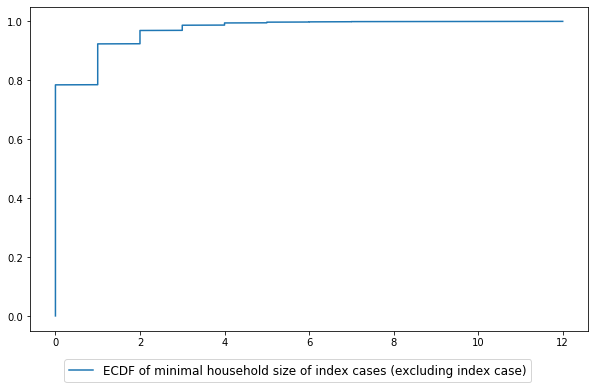

In [136]:
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10, 6))
# ax.plot(hs_ecdf.x, hs_ecdf.y, label='ECDF of minimal household size of index cases (including large households)')
ax.plot(hs2_ecdf.x, hs2_ecdf.y, label='ECDF of minimal household size of index cases (excluding index case)')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',  prop={'size': 12})
fig.subplots_adjust(bottom=0.13)
plt.savefig('ecdf_secondary_household_size.png', bbox_inches='tight')
plt.show()

## Mean household size in General Populations

In [137]:
def get_household_sizes_in_poland():
    from collections import Counter, defaultdict
    from pathlib import Path
    
    household_sizes_in_poland_path = Path(r'd:\coronavirus\hospitalizations\household_sizes_in_poland.csv').resolve()
    if household_sizes_in_poland_path.is_file():
        household_sizes_in_poland = pd.read_csv(str(household_sizes_in_poland_path))
    else:
        nsp_folder = Path(r'data/simulations/nsp2011_powiats/apartments').resolve()    
        household_counter = Counter()
        for folder in nsp_folder.iterdir():
            popul_voy = pd.read_csv(str(folder / 'population.csv'))
            grouped = popul_voy.groupby(by=en.prop_household).size().reset_index().rename(columns={0: 'headcount'})
            household_counter.update(grouped.groupby(by='headcount').size().to_dict())
        household_sizes_in_poland = pd.DataFrame(data={
            'household_size': list(household_counter.keys()), 
            'household_count': list(household_counter.values())})
        household_sizes_in_poland.to_csv(str(household_sizes_in_poland_path), index=False, encoding='utf-8')
    return household_sizes_in_poland

In [138]:
household_sizes_in_poland = get_household_sizes_in_poland()

In [139]:
sum_of_numbers = (household_sizes_in_poland['household_size'] * household_sizes_in_poland['household_count']).sum()
count = household_sizes_in_poland['household_count'].sum()
mean = sum_of_numbers / count

In [140]:
print(f'Average size of a household (equivalent to flat/apartment according to GUS naming convention): {mean}')

Average size of a household (equivalent to flat/apartment according to GUS naming convention): 3.349991265937464


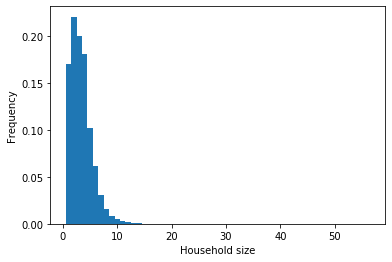

In [141]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.figure()
plt.bar(household_sizes_in_poland['household_size'], 
        household_sizes_in_poland['household_count']/household_sizes_in_poland['household_count'].sum(), width=1)
plt.xlabel('Household size')
plt.ylabel('Frequency')
# plt.title('Frequency of occurrence of households of given headcount in Poland')
plt.savefig('PL_household_sizes_in_poland.png')
plt.show()

In [151]:
household_sizes_in_poland_sample = []
for idx, row in household_sizes_in_poland.iterrows():
    if row.household_size < 15:
        household_sizes_in_poland_sample.extend([row.household_size] * row.household_count)

In [152]:
ecdf_household_sizes_in_poland = ECDF(household_sizes_in_poland_sample)

In [144]:
new_spreaders_household_sizes = []

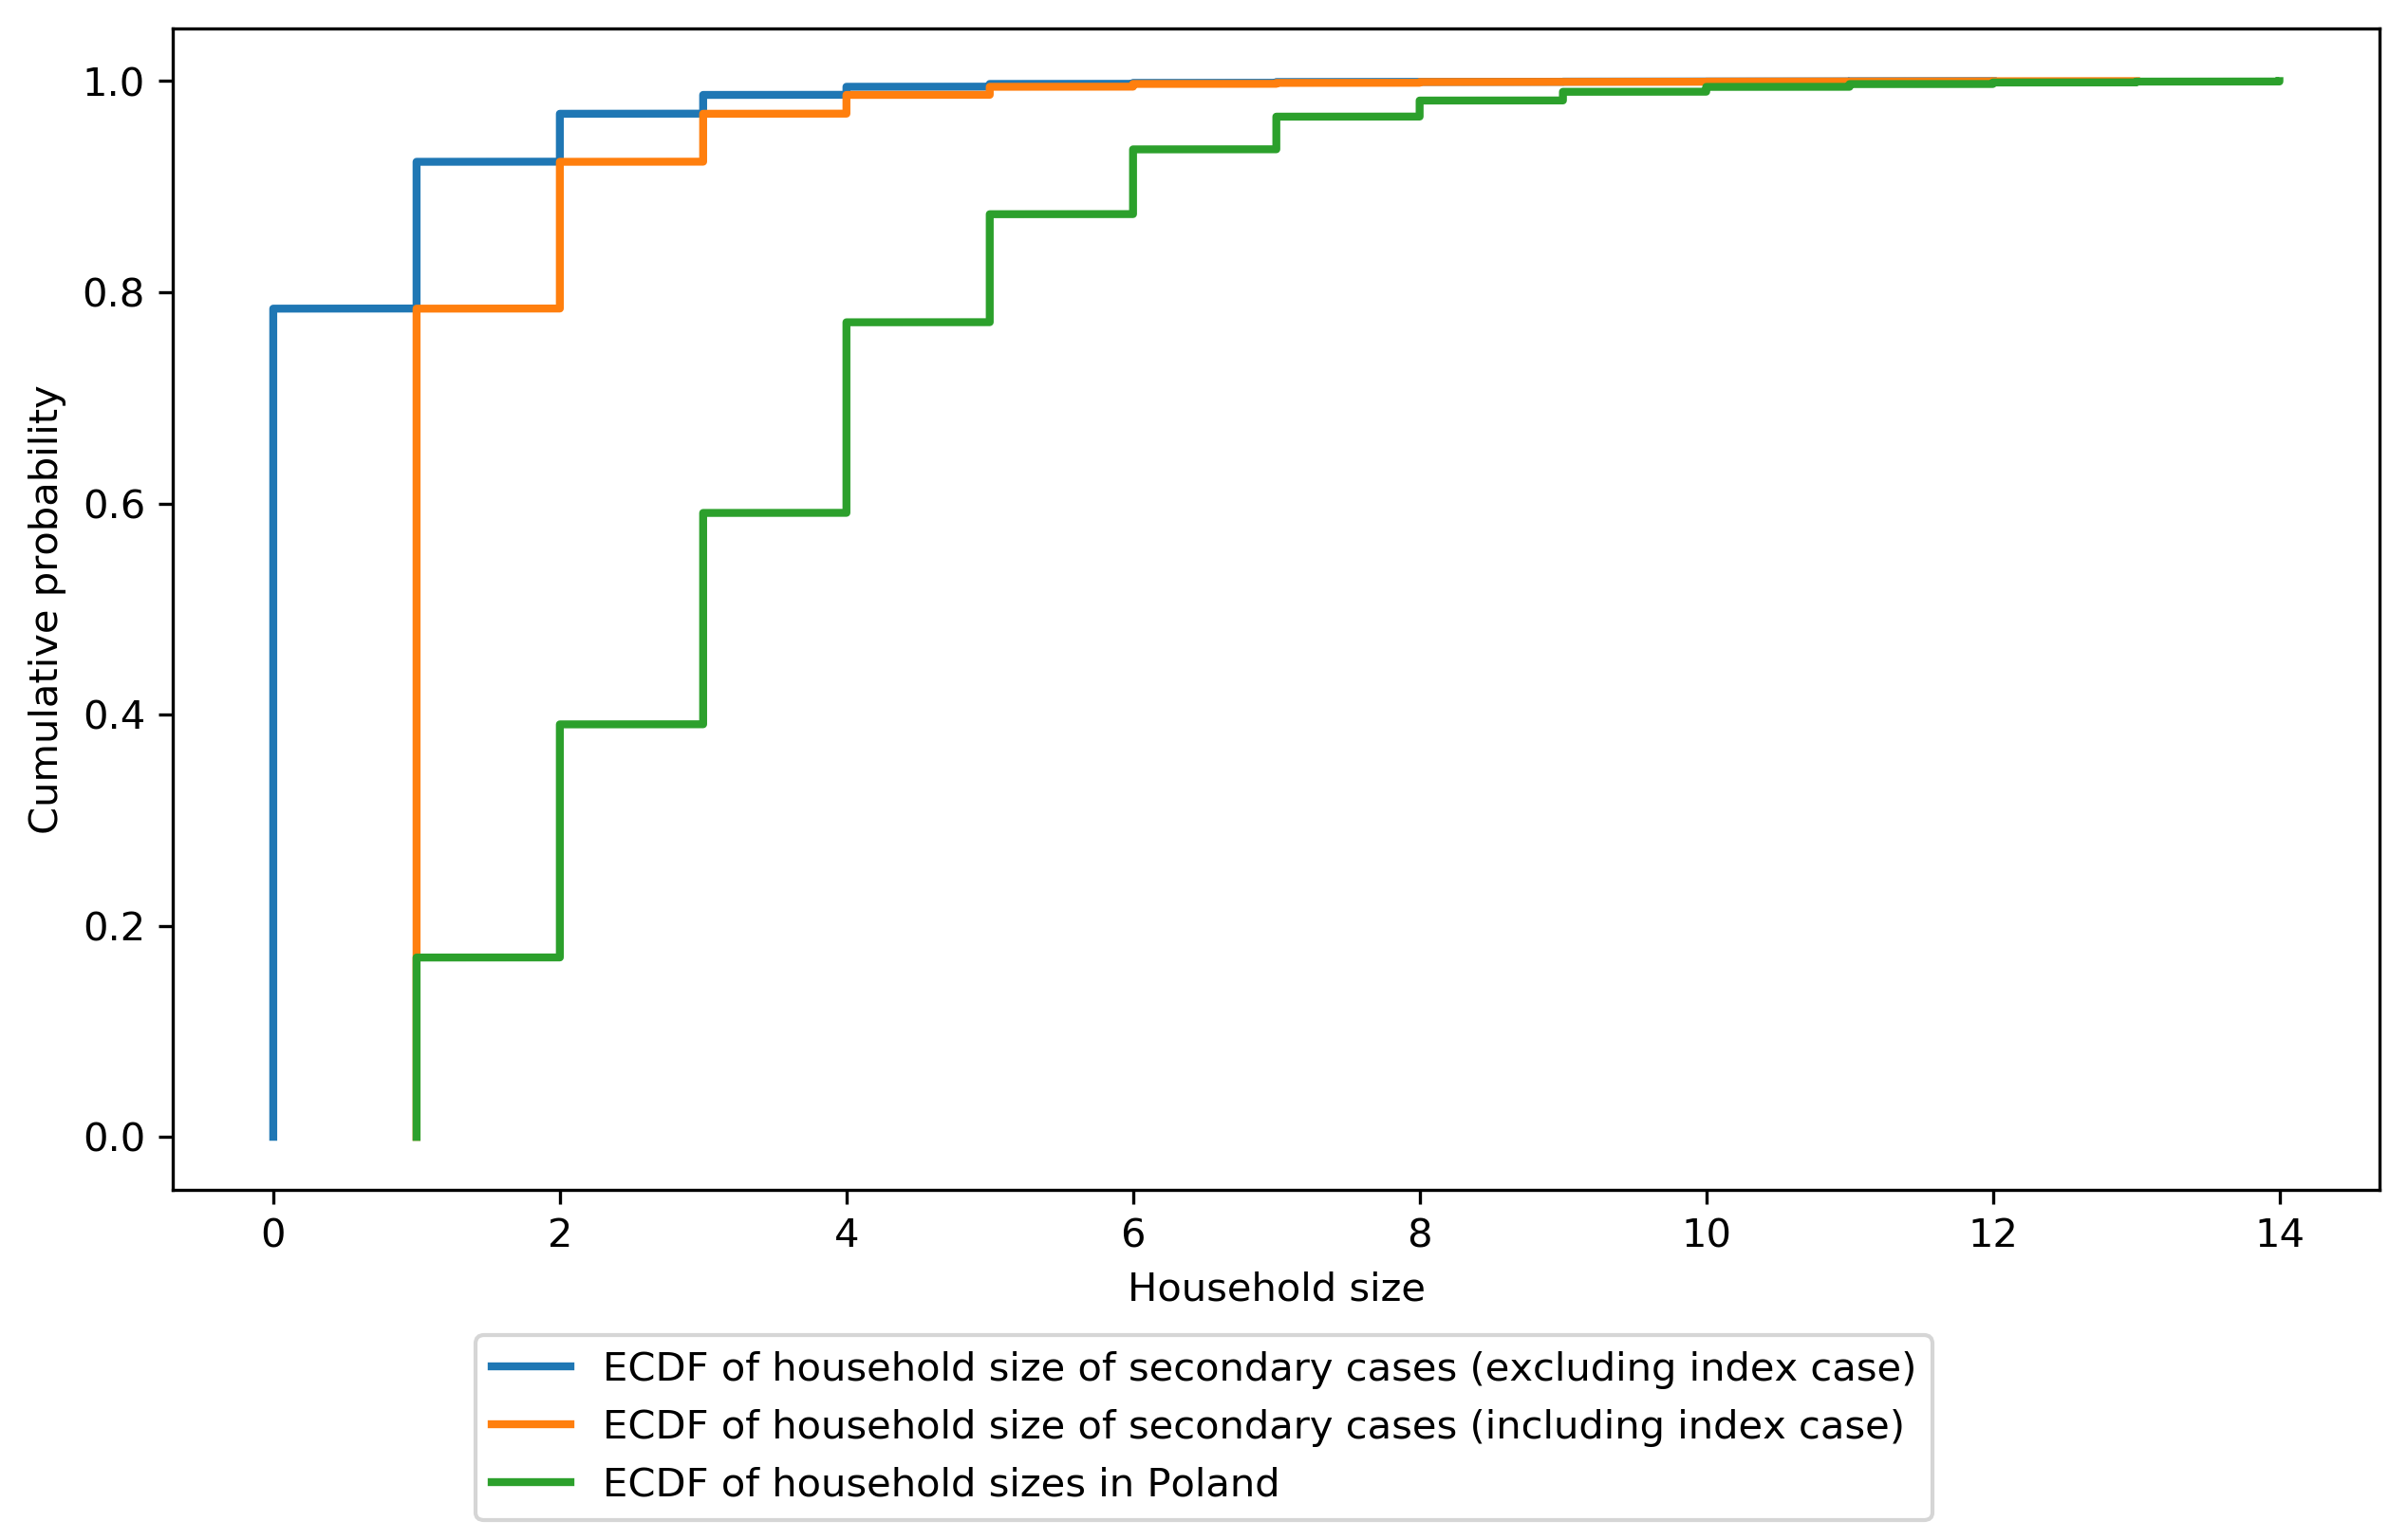

In [153]:
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10, 6), dpi=300)
# ax.plot(hs_ecdf.x, hs_ecdf.y, label='ECDF of household size of secondary cases (excluding index case, including large households)', lw=2, linestyle='-')
ax.plot(hs2_ecdf.x, hs2_ecdf.y, label='ECDF of household size of secondary cases (excluding index case)', lw=2, linestyle='-')
# ax.plot(hs3_ecdf.x, hs3_ecdf.y, label='ECDF of household size of secondary cases (including index case, including large households)', lw=2, linestyle='-')
ax.plot(hs3_2_ecdf.x, hs3_2_ecdf.y, label='ECDF of household size of secondary cases (including index case)', lw=2, linestyle='-')
plt.plot(ecdf_household_sizes_in_poland.x, ecdf_household_sizes_in_poland.y, label='ECDF of household sizes in Poland', lw=2, linestyle='-')
handles, labels = ax.get_legend_handles_labels()
plt.xlabel('Household size')
plt.ylabel('Cumulative probability')
fig.legend(handles, labels, loc='lower center',  prop={'size': 10})
fig.subplots_adjust(bottom=0.2)
plt.savefig('ecdf_secondary_household_size_2.png', bbox_inches='tight')
plt.show()

### Histogram of household sizes

In [93]:
spreaders_household_sizes = []

for node in df2[~df2.earliest_age_in_address.isna()].earliest_age_in_address.astype(int):
    spreaders_household_sizes.append(mean_household_size_given_age_dict[node] - 1)    

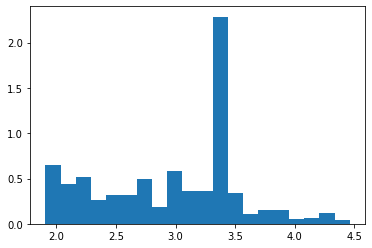

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
plt.hist(spreaders_household_sizes, bins=20, density=True)
# plt.title('Histogram of household sizes of infected people')
plt.savefig('secondary_infections_household_sizes_20200624.png')
plt.show()

In [92]:
ecdf_spreaders_household_sizes = ECDF(spreaders_household_sizes)

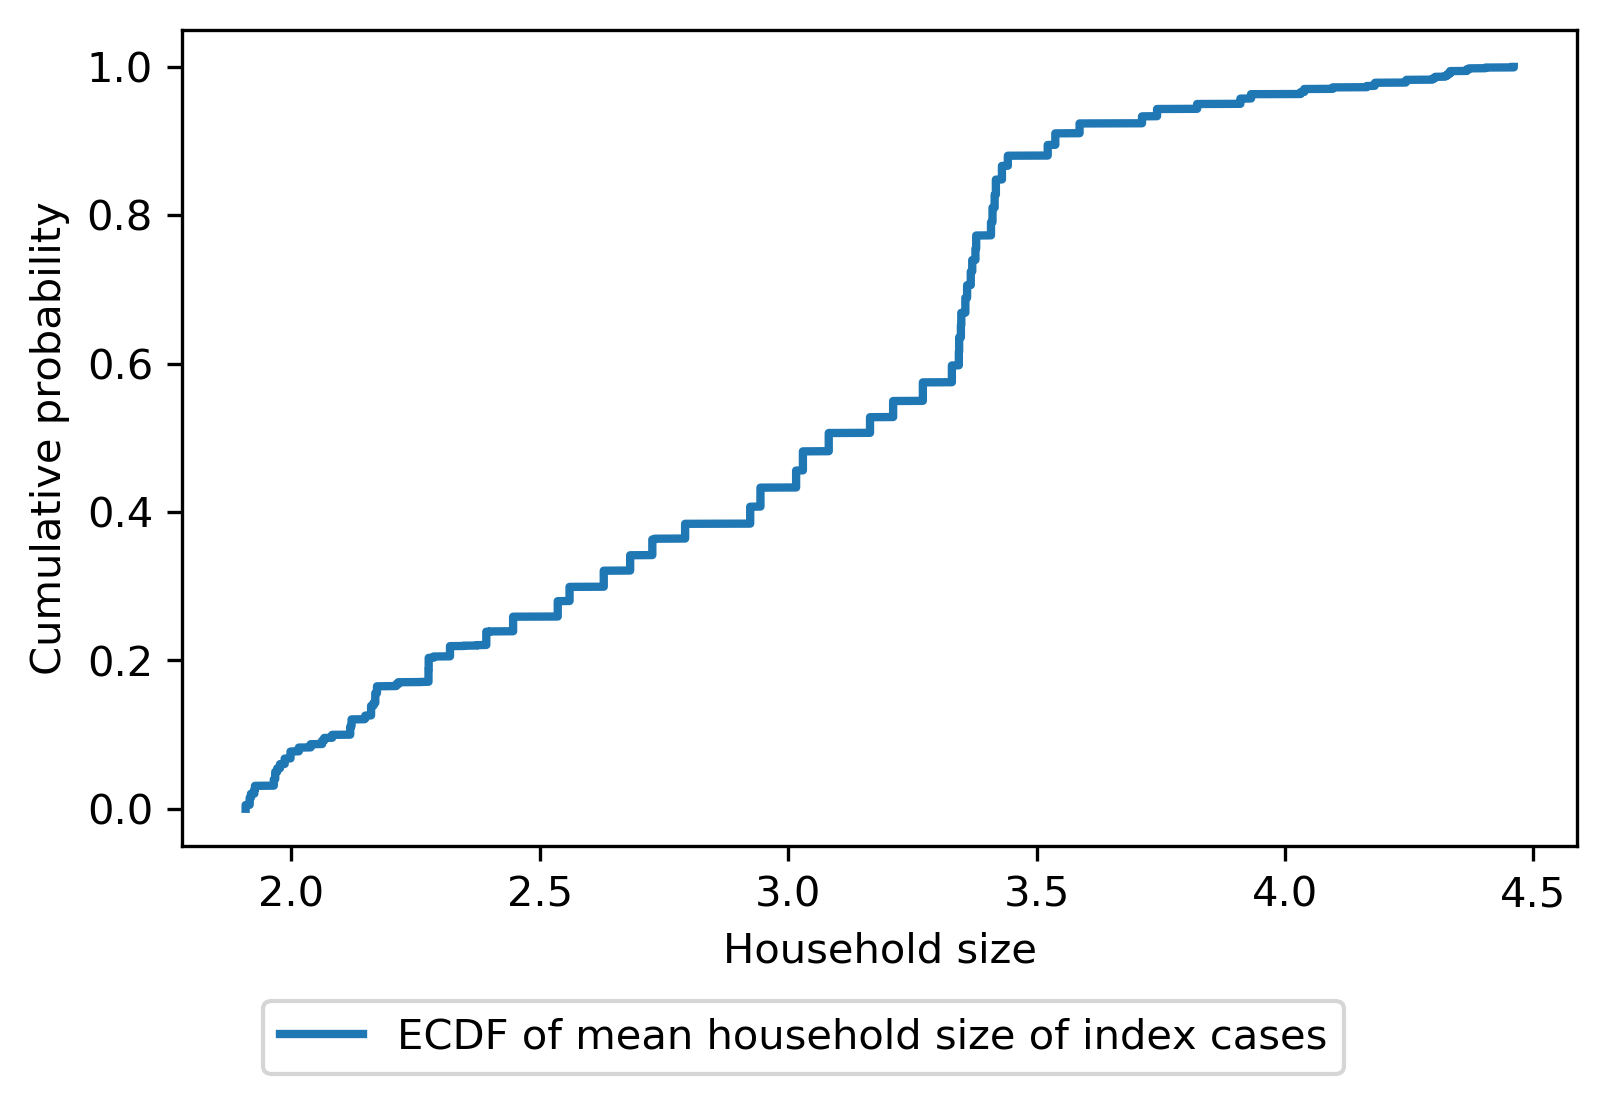

In [99]:
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(nrows=1,ncols=1, dpi=300)
ax.plot(ecdf_spreaders_household_sizes.x, ecdf_spreaders_household_sizes.y, 
        label='ECDF of mean household size of index cases', 
        lw=2, linestyle='-')
handles, labels = ax.get_legend_handles_labels()
plt.xlabel('Household size')
plt.ylabel('Cumulative probability')
fig.legend(handles, labels, loc='lower center',  prop={'size': 10})
fig.subplots_adjust(bottom=0.2)
plt.savefig('ecdf_household_size_index_cases.png', bbox_inches='tight')
plt.show()

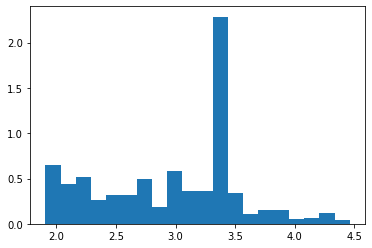

In [123]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
plt.hist(spreaders_household_sizes, bins=20, density=True)
plt.savefig('secondary_infections_household_sizes.png')
plt.show()

In [124]:
spreaders_households_ecdf = ECDF(spreaders_household_sizes)

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10, 6))
ax.plot(spreaders_households_ecdf.x, spreaders_households_ecdf.y, label='ECDF of mean household size of index cases (excluding index case, based on 2011 Census data)')
ax.plot(hs2_ecdf.x, hs2_ecdf.y, label='ECDF of minimal household size of index cases (excluding index case)')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',  prop={'size': 12})
fig.subplots_adjust(bottom=0.13)
plt.savefig('ecdf_secondary_household_size.png', bbox_inches='tight')
plt.show()